In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 15.2 MB/s 


In [ ]:
!unzip -q ../gdrive/MyDrive/ANNDL/Homework1/training_dataset_homework1.zip 

replace training_data_final/Species1/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
import os
import random

!pip install split-folders

import splitfolders
dataset_dir = 'splitted'

splitfolders.ratio('training_data_final', output=dataset_dir, seed=seed, ratio=(.75, .15, .1), group_prefix=None) # default values

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3542 files [00:00, 8446.69 files/s]


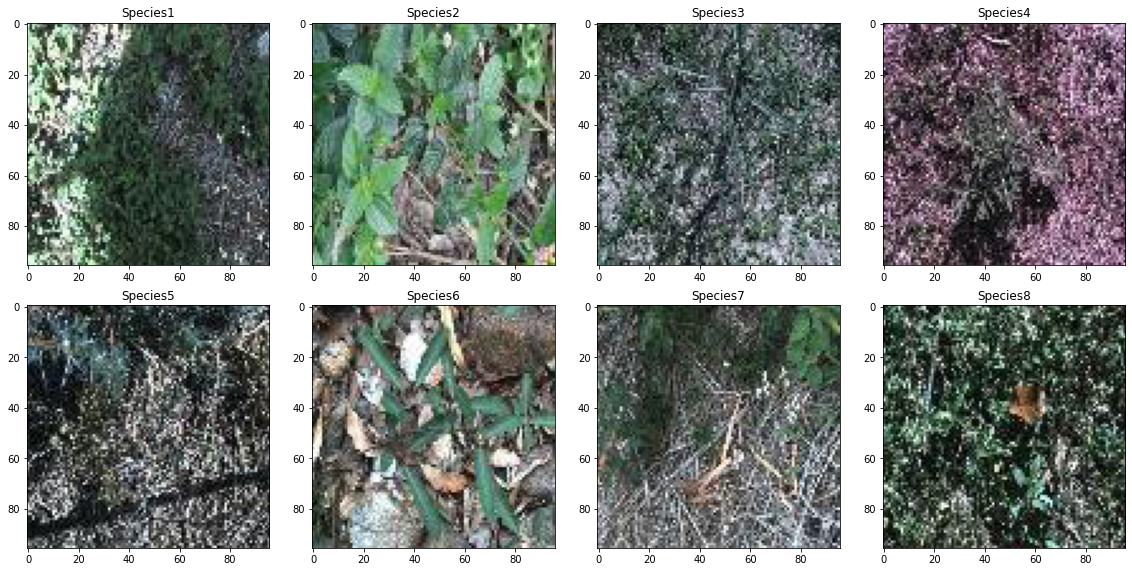

In [ ]:
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Plot example images from dataset
labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//3
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,2*num_col))
for i in range(len(labels)):
  class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
  class_img = class_imgs[0]
  img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
  #print(np.array(img))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of training images per category:')

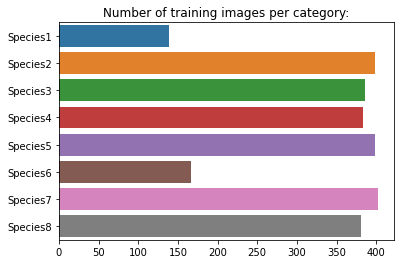

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(
                                        brightness_range=[0.7,1.5],
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        cval=0,
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255.
                                        ) 
aug_valid_data_gen = ImageDataGenerator(
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [ ]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)


aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None,
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=False,
                                             seed=seed)

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
      
  callbacks = []

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

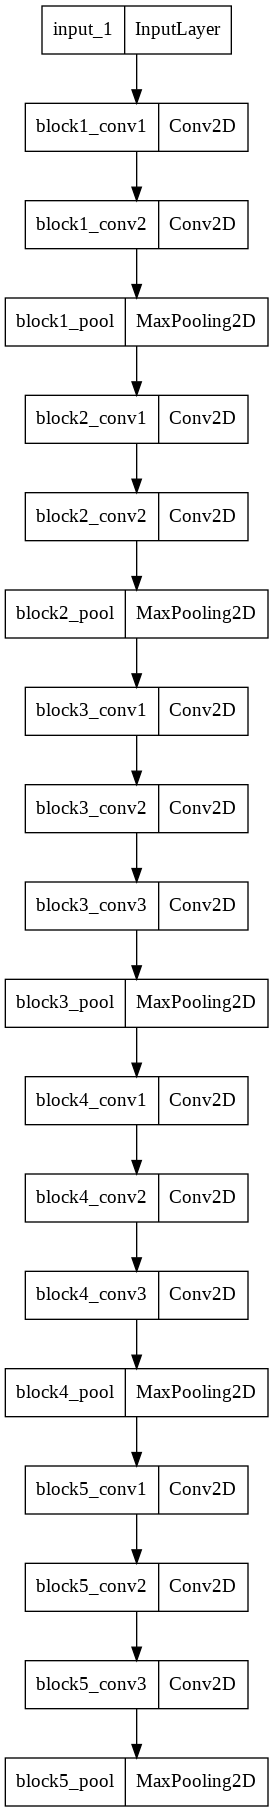

In [ ]:

# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [ ]:
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=len(labels), activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:

class_weight = {0:2.8,1:1.,2:1.,3:1.,4:1.,5:2.,6:1.,7:1.}

In [ ]:
tl_callbacks = create_folders_and_callbacks(model_name = 'aug_transfer_learning_balanced_VGG')
# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_valid_gen,
    callbacks = tl_callbacks,
    class_weight=class_weight,
).history

Epoch 1/200
331/332 [============================>.] - ETA: 0s - loss: 1.3085 - accuracy: 0.6980 - precision_2: 0.7514 - recall_2: 0.6534

332/332 [==============================] - 19s 54ms/step - loss: 1.3077 - accuracy: 0.6978 - precision_2: 0.7510 - recall_2: 0.6534 - val_loss: 0.9637 - val_accuracy: 0.7116 - val_precision_2: 0.7728 - val_recall_2: 0.6584
Epoch 2/200
332/332 [==============================] - ETA: 0s - loss: 0.9502 - accuracy: 0.7362 - precision_2: 0.8111 - recall_2: 0.6650

332/332 [==============================] - 17s 52ms/step - loss: 0.9502 - accuracy: 0.7362 - precision_2: 0.8111 - recall_2: 0.6650 - val_loss: 0.8992 - val_accuracy: 0.7211 - val_precision_2: 0.8028 - val_recall_2: 0.6490
Epoch 3/200
331/332 [============================>.] - ETA: 0s - loss: 0.8452 - accuracy: 0.7608 - precision_2: 0.8394 - recall_2: 0.7029

332/332 [==============================] - 17s 52ms/step - loss: 0.8456 - accuracy: 0.7600 - precision_2: 0.8384 - recall_2: 0.7016 - val_loss: 0.8974 - val_accuracy: 0.6509 - val_precision_2: 0.7264 - val_recall_2: 0.5693
Epoch 4/200
331/332 [============================>.] - ETA: 0s - loss: 0.8476 - accuracy: 0.7502 - precision_2: 0.8390 - recall_2: 0.6776

332/332 [==============================] - 18s 53ms/step - loss: 0.8465 - accuracy: 0.7506 - precision_2: 0.8392 - recall_2: 0.6782 - val_loss: 0.9076 - val_accuracy: 0.6964 - val_precision_2: 0.7849 - val_recall_2: 0.6509
Epoch 5/200
331/332 [============================>.] - ETA: 0s - loss: 0.8267 - accuracy: 0.7521 - precision_2: 0.8281 - recall_2: 0.6882

332/332 [==============================] - 17s 52ms/step - loss: 0.8290 - accuracy: 0.7517 - precision_2: 0.8285 - recall_2: 0.6880 - val_loss: 0.9382 - val_accuracy: 0.7135 - val_precision_2: 0.7808 - val_recall_2: 0.6490
Epoch 6/200
331/332 [============================>.] - ETA: 0s - loss: 0.8259 - accuracy: 0.7562 - precision_2: 0.8374 - recall_2: 0.6909

332/332 [==============================] - 18s 53ms/step - loss: 0.8282 - accuracy: 0.7562 - precision_2: 0.8370 - recall_2: 0.6907 - val_loss: 0.9666 - val_accuracy: 0.7040 - val_precision_2: 0.7632 - val_recall_2: 0.6603
Epoch 7/200
331/332 [============================>.] - ETA: 0s - loss: 0.8233 - accuracy: 0.7683 - precision_2: 0.8506 - recall_2: 0.6973

332/332 [==============================] - 18s 53ms/step - loss: 0.8223 - accuracy: 0.7690 - precision_2: 0.8511 - recall_2: 0.6978 - val_loss: 0.9520 - val_accuracy: 0.6433 - val_precision_2: 0.7000 - val_recall_2: 0.5844
Epoch 8/200
332/332 [==============================] - ETA: 0s - loss: 0.8391 - accuracy: 0.7570 - precision_2: 0.8365 - recall_2: 0.6865

332/332 [==============================] - 17s 52ms/step - loss: 0.8391 - accuracy: 0.7570 - precision_2: 0.8365 - recall_2: 0.6865 - val_loss: 1.0094 - val_accuracy: 0.6622 - val_precision_2: 0.7454 - val_recall_2: 0.6110
Epoch 9/200
332/332 [==============================] - ETA: 0s - loss: 0.8385 - accuracy: 0.7472 - precision_2: 0.8444 - recall_2: 0.6790

332/332 [==============================] - 18s 53ms/step - loss: 0.8385 - accuracy: 0.7472 - precision_2: 0.8444 - recall_2: 0.6790 - val_loss: 1.0140 - val_accuracy: 0.6565 - val_precision_2: 0.7302 - val_recall_2: 0.6110
Epoch 10/200
331/332 [============================>.] - ETA: 0s - loss: 0.8052 - accuracy: 0.7555 - precision_2: 0.8316 - recall_2: 0.6810

332/332 [==============================] - 19s 57ms/step - loss: 0.8050 - accuracy: 0.7551 - precision_2: 0.8312 - recall_2: 0.6809 - val_loss: 0.9690 - val_accuracy: 0.6717 - val_precision_2: 0.7500 - val_recall_2: 0.6262
Epoch 11/200
331/332 [============================>.] - ETA: 0s - loss: 0.8293 - accuracy: 0.7532 - precision_2: 0.8341 - recall_2: 0.6859

332/332 [==============================] - 17s 53ms/step - loss: 0.8278 - accuracy: 0.7536 - precision_2: 0.8342 - recall_2: 0.6865 - val_loss: 0.9165 - val_accuracy: 0.6926 - val_precision_2: 0.7770 - val_recall_2: 0.6281
Epoch 12/200
332/332 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.7619 - precision_2: 0.8590 - recall_2: 0.6933

332/332 [==============================] - 17s 52ms/step - loss: 0.8096 - accuracy: 0.7619 - precision_2: 0.8590 - recall_2: 0.6933 - val_loss: 0.9188 - val_accuracy: 0.6660 - val_precision_2: 0.7512 - val_recall_2: 0.6072
Epoch 13/200
331/332 [============================>.] - ETA: 0s - loss: 0.8135 - accuracy: 0.7559 - precision_2: 0.8379 - recall_2: 0.6897

332/332 [==============================] - 18s 54ms/step - loss: 0.8127 - accuracy: 0.7566 - precision_2: 0.8383 - recall_2: 0.6895 - val_loss: 0.9852 - val_accuracy: 0.6546 - val_precision_2: 0.7279 - val_recall_2: 0.6091
Epoch 14/200
331/332 [============================>.] - ETA: 0s - loss: 0.8025 - accuracy: 0.7502 - precision_2: 0.8407 - recall_2: 0.6841

332/332 [==============================] - 18s 53ms/step - loss: 0.8015 - accuracy: 0.7502 - precision_2: 0.8411 - recall_2: 0.6843 - val_loss: 1.1269 - val_accuracy: 0.7040 - val_precision_2: 0.7721 - val_recall_2: 0.6622
Epoch 15/200
332/332 [==============================] - ETA: 0s - loss: 0.8354 - accuracy: 0.7521 - precision_2: 0.8406 - recall_2: 0.6775

332/332 [==============================] - 18s 53ms/step - loss: 0.8354 - accuracy: 0.7521 - precision_2: 0.8406 - recall_2: 0.6775 - val_loss: 0.9612 - val_accuracy: 0.6907 - val_precision_2: 0.7639 - val_recall_2: 0.6262
Epoch 16/200
332/332 [==============================] - ETA: 0s - loss: 0.8047 - accuracy: 0.7506 - precision_2: 0.8447 - recall_2: 0.6786

332/332 [==============================] - 17s 52ms/step - loss: 0.8047 - accuracy: 0.7506 - precision_2: 0.8447 - recall_2: 0.6786 - val_loss: 1.0201 - val_accuracy: 0.6755 - val_precision_2: 0.7220 - val_recall_2: 0.6110
Epoch 17/200
331/332 [============================>.] - ETA: 0s - loss: 0.7932 - accuracy: 0.7475 - precision_2: 0.8402 - recall_2: 0.6818

332/332 [==============================] - 18s 54ms/step - loss: 0.7938 - accuracy: 0.7476 - precision_2: 0.8407 - recall_2: 0.6820 - val_loss: 0.9479 - val_accuracy: 0.7154 - val_precision_2: 0.7805 - val_recall_2: 0.6546


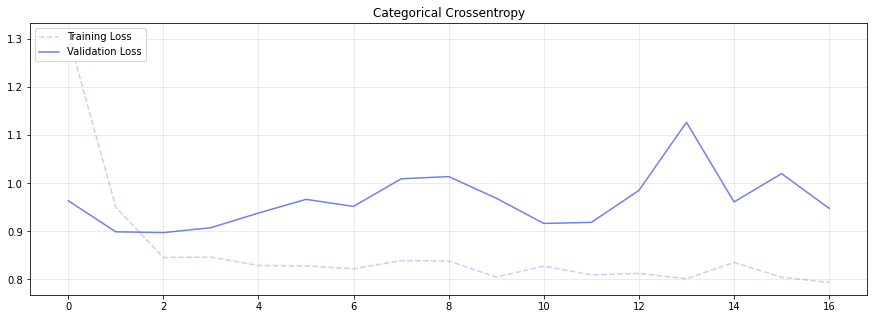

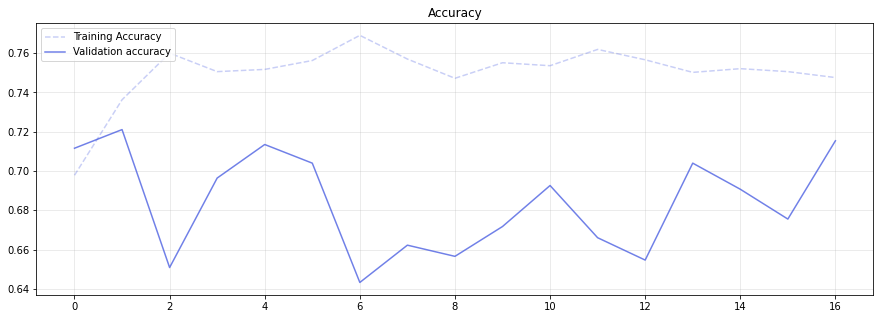

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
tl_model.save('/gdrive/MyDrive/ANNDL/Homework1/models/Franc/aug_transfer_learning_balanced_VGG_small_batch')

In [ ]:
# Re-load the model after transfer learning
tl_model = tfk.models.load_model('/gdrive/MyDrive/ANNDL/Homework1/models/Franc/aug_transfer_learning_balanced_VGG_small_batch')
tl_model.summary()

In [ ]:
# Set all VGG layers to True
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

In [ ]:
# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = 200,
    validation_data = aug_valid_gen,
    class_weight=class_weight,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)]
).history

Epoch 1/200
332/332 [==============================] - 18s 49ms/step - loss: 1.0359 - accuracy: 0.7163 - precision_3: 0.8246 - recall_3: 0.6021 - val_loss: 1.2016 - val_accuracy: 0.6452 - val_precision_3: 0.7370 - val_recall_3: 0.5370
Epoch 2/200
332/332 [==============================] - 16s 48ms/step - loss: 1.0166 - accuracy: 0.7084 - precision_3: 0.8225 - recall_3: 0.6040 - val_loss: 1.1995 - val_accuracy: 0.6167 - val_precision_3: 0.7351 - val_recall_3: 0.5370
Epoch 3/200
332/332 [==============================] - 16s 47ms/step - loss: 0.9591 - accuracy: 0.7276 - precision_3: 0.8360 - recall_3: 0.6300 - val_loss: 1.0462 - val_accuracy: 0.6641 - val_precision_3: 0.7812 - val_recall_3: 0.5825
Epoch 4/200
332/332 [==============================] - 16s 47ms/step - loss: 0.9734 - accuracy: 0.7276 - precision_3: 0.8146 - recall_3: 0.6274 - val_loss: 1.1480 - val_accuracy: 0.5332 - val_precision_3: 0.6332 - val_recall_3: 0.4194
Epoch 5/200
332/332 [==============================] - 16s 4

In [ ]:
#Save the best model
tl_model.save('/gdrive/MyDrive/ANNDL/Homework1/models/Franc/aug_transfer_learning_balanced_VGG_tuned_correctly_small_batch')

In [ ]:
model_to_be_tested = tfk.models.load_model("/gdrive/MyDrive/ANNDL/Homework1/models/Franc/aug_transfer_learning_balanced_VGG_tuned_correctly_small_batch")
model_to_be_tested_metrics = model_to_be_tested.evaluate(test_gen, return_dict=True)


46/46 [==============================] - 2s 24ms/step
[7 0 3 7 1 0 7 3 2 3 3 7 7 0 7 1 0 7 7 3 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 3 1 6 3 1 7 1 1 1 1 1 6 1 4 1 1 1 1 1 6 1 1
 2 2 2 2 2 2 2 2 4 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 4 3 3 4 3 2 4 4 2 4 2 4 4
 4 4 4 4 3 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 3 4 4 4 4 4 4 4
 4 4 4 4 4 2 4 4 4 4 5 5 5 5 5 5 5 5 5 0 0 1 5 5 5 5 3 5 5 4 4 1 5 6 6 6 6
 1 6 7 6 6 6 6 2 6 6 6 6 6 6 0 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 6 6 6 6 6 6 6
 7 6 6 6 6 6 6 7 6 6 1 6 6 6 3 7 7 7 0 7 7 7 2 7 3 7 7 0 7 1 7 3 7 7 7 7 7
 7 7 0 1 7 7 7 7 0 7 3 7 7 7 7 7 6 7 7 7 3 7 7 7 7 7 7 7]
Accuracy: 0.8033
Precision: 0.7759
Recall: 0.7484
F1: 0.7555


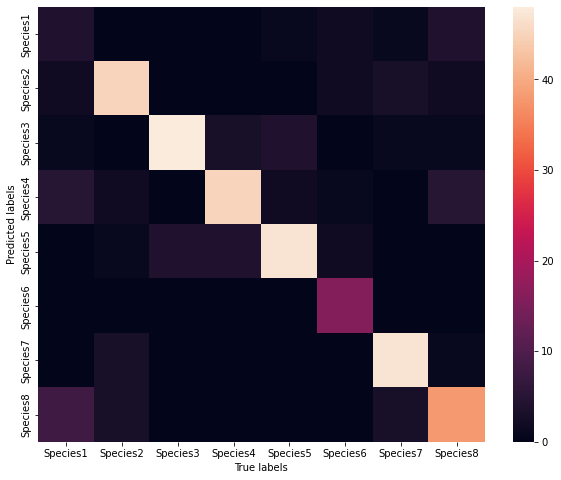

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = model_to_be_tested.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))

              precision    recall  f1-score   support

           0       0.33      0.20      0.25        20
           1       0.83      0.83      0.83        54
           2       0.83      0.92      0.87        52
           3       0.75      0.87      0.80        52
           4       0.81      0.87      0.84        54
           5       1.00      0.70      0.82        23
           6       0.92      0.85      0.89        55
           7       0.73      0.75      0.74        51

    accuracy                           0.80       361
   macro avg       0.78      0.75      0.76       361
weighted avg       0.80      0.80      0.80       361

